<a href="https://colab.research.google.com/github/Akash-Rayhan/Resume-Filtering-System/blob/main/notebooks/LSTM_model_bert_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U "tensorflow-text==2.8.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 31.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-datasets 4.9.2 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tens

In [39]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LSTM, Bidirectional, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
dataframe = pd.read_csv('/content/drive/MyDrive/Datasets/resume_dataset/Resume/Resume.csv')
dataframe.drop(columns = ['ID', 'Resume_html'], inplace = True)
dataframe.head()

,Resume_str,Category
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,HR DIRECTOR Summary Over 2...,HR
3,HR SPECIALIST Summary Dedica...,HR
4,HR MANAGER Skill Highlights ...,HR


In [4]:
stop_words = stopwords.words('english')
# stemmer = nltk.SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    '''Make text lowercase,remove extra whitespaces, remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\s+', ' ', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split(' '))

    return text

In [5]:
dataframe['Resume_str'] = dataframe['Resume_str'].apply(preprocess_data)

In [6]:
le = LabelEncoder()
le.fit(dataframe['Category'])
dataframe['Category'] = le.transform(dataframe['Category'])

In [ ]:
len(le.classes_)

24

In [7]:
features = dataframe['Resume_str'].values
targets = dataframe['Category'].values

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(features,targets,random_state=42, test_size=0.2,
                                                 shuffle=True, stratify=targets)

In [34]:
# Load BERT and the preprocessing model from TF Hub.
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/2",trainable=True)

In [35]:
feature_input = Input(shape=(), dtype="string", name="word_features")
# Use BERT on a batch of raw text inputs.
input = preprocessor(feature_input)
desc_embedding = encoder(input)["sequence_output"]
lstm_layer = Bidirectional(LSTM(units=64))(desc_embedding)
dense_layer = Dense(64, activation="relu", name="dense_layer")(lstm_layer)
drop_out = Dropout(0.25)(dense_layer)
output = Dense(24,activation="softmax",name="softmax")(drop_out)
model = Model(inputs=feature_input, outputs=output)

In [28]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 word_features (InputLayer)     [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['word_features[0][0]']          
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

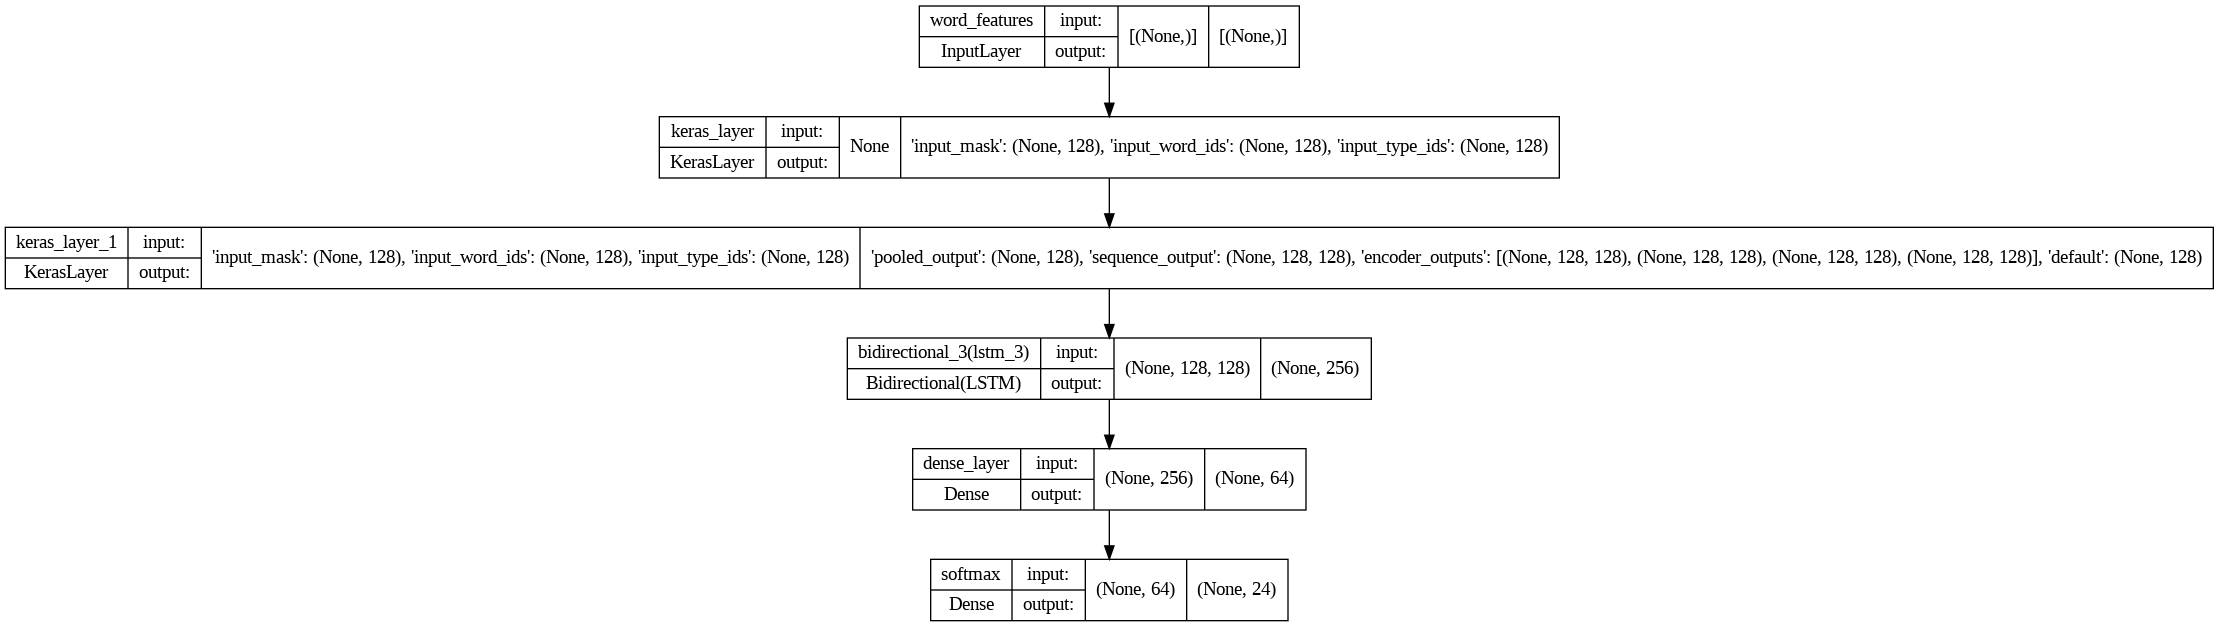

In [18]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [36]:
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=['sparse_categorical_accuracy'],
)

In [37]:
history = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64)


Epoch 1/20
32/32 [==============================] - 24s 500ms/step - loss: 3.1890 - sparse_categorical_accuracy: 0.0549 - val_loss: 3.1564 - val_sparse_categorical_accuracy: 0.0483
Epoch 2/20
32/32 [==============================] - 14s 436ms/step - loss: 3.1513 - sparse_categorical_accuracy: 0.0544 - val_loss: 3.0139 - val_sparse_categorical_accuracy: 0.0845
Epoch 3/20
32/32 [==============================] - 14s 443ms/step - loss: 2.6856 - sparse_categorical_accuracy: 0.2396 - val_loss: 2.2608 - val_sparse_categorical_accuracy: 0.3742
Epoch 4/20
32/32 [==============================] - 15s 466ms/step - loss: 1.9189 - sparse_categorical_accuracy: 0.4972 - val_loss: 1.5233 - val_sparse_categorical_accuracy: 0.6298
Epoch 5/20
32/32 [==============================] - 15s 467ms/step - loss: 1.4475 - sparse_categorical_accuracy: 0.6236 - val_loss: 1.1907 - val_sparse_categorical_accuracy: 0.7022
Epoch 6/20
32/32 [==============================] - 15s 468ms/step - loss: 1.2545 - sparse_cate

In [40]:
predict = np.argmax(model.predict(X_test),axis=1)
print('Test Data accuracy: ',accuracy_score(y_test, predict)*100)
print("\nConfusion Matrix : ")
cnf_matrix = confusion_matrix(y_test, predict)
print(cnf_matrix)
print("\nClassification Report :")
print(classification_report(y_test, predict, target_names=le.classes_))

Test Data accuracy:  72.43460764587525

Confusion Matrix : 
[[22  0  0  0  0  0  0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 19  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  1  0]
 [ 0  0  3  3  1  0  1  0  0  0  0  1  0  0  0  0  0  0  1  0  1  2  0  0]
 [ 0  0  1  8  0  0  0  0  0  1  0  0  0  2  1  0  0  1  0  0  1  1  2  1]
 [ 0  1  0  4  7  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  3  0  4]
 [ 0  0  0  1  0  0  0  3  0  0  0  0  0  0  0  0  0  0  1  0  2  0  0  0]
 [ 0  0  0  4  0  0 13  3  0  0  0  0  0  0  0  1  0  1  2  0  0  0  0  0]
 [ 0  0  0  1  1  1  0 15  0  2  0  0  0  0  0  0  0  0  0  0  1  1  1  0]
 [ 0  0  0  2  0  0  0  1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 23  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  2  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  1  0  0  1]
 [ 0  0  0  1  0  0  0  0  0  0  0 20  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0 22

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


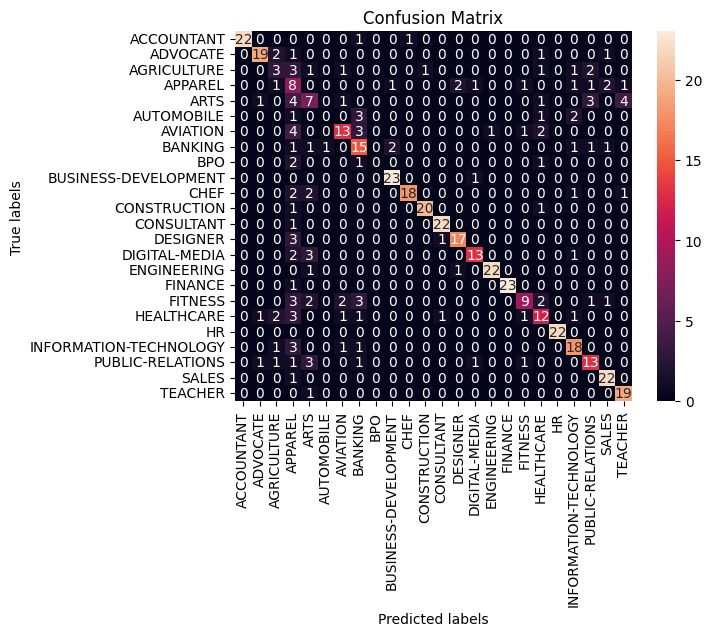

In [41]:
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(le.classes_); ax.yaxis.set_ticklabels(le.classes_);